# **Multiclass Classification of X-ray Radiographs with Transfer Learning (DenseNet-169).**

This notebook serves as a **self-educational** project in which knowledge derived from other projects and documentation from the TensorFlow guidelines is applied to a multiclass classification task of X-ray images.

This only features the initialisation and fine-tuning of the **DenseNet-169** pretrained model. This is to validate each component in the pipeline, i.e., **model initialisation**, **training**, **prediction**, **corresponding functions**. Once validated, these code components can modularised.

The main project in which all models are trained and evaluated on the classification task is in the **`PCXR-model-training-and-eval.ipnyb`** notebook.

## **Importing Required Libraries**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt                # Visualise images

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'       # Suppress TF messages
import tensorflow as tf
from keras.callbacks import TensorBoard        # Track metrics
print("TensorFlow version: ", tf.__version__)  # Check TF version

# Check TensorFlow is using the GPU -- for local machine:
# gpu = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu[0], True)

# Mount Google Drive -- for Colab environment:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# Convert ipynb notebook to html
PROJECT_ROOT = "/content/drive/MyDrive/Pneumonia-Xray-Classification"
NB_NAME = "PCXR-transfer-learning-with-densenet-169.ipynb"
NB_DIR = os.path.join(PROJECT_ROOT, "notebooks")
CURR_NB = os.path.join(NB_DIR, NB_NAME)

print("Converting", NB_NAME, "to HTML.")

%pip install nbconvert
%jupyter nbconvert --to html CURR_NB

/content/drive/MyDrive/Pneumonia-Xray-Classification/notebooks/PCXR-transfer-learning-with-densenet-169.ipynb


## **Data Loading Phase**

Here, the data is loaded into the environment with the `image_dataset_from_directory` function, which yields batches of images in the form of `tf.data.Dataset`. For this project, the batch size is configured to 32 images, while the dimensions of each image is configured to a (224, 224) shape. Finally, a validation split of 0.2 is configured for the validation set.

The total number of images per class is also computed below, to check for class imbalance. There is a 2:1:1 ratio spread between the classes, which is a relatively balanced dataset. This is important as it determines which evaluation metrics should be implemented to more accurately reflect model performance.

In [ ]:
# Configure directories -- for local machine:
# TRAIN_DIR = "../images/train"
# TEST_DIR = "../images/test"

# Configure directories -- for Colab environment:
TRAIN_DIR = os.path.join(PROJECT_ROOT, "images/train")
TEST_DIR = os.path.join(PROJECT_ROOT, "images/test")

# Additional configurations for data loading
CLS_NAMES = ["normal", "bacteria", "virus"]
BATCH_SIZE = 32
IMG_SIZE = (300, 300)

# Load in datasets (tf.data.Dataset)
print("Training and validation data set loading...")
train_ds, valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    label_mode="int",
    class_names=CLS_NAMES,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="both")

print("\nTesting data set loading...")
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    label_mode="int",
    class_names=CLS_NAMES,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    subset=None)

Training and validation data set loading...
Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.

Testing data set loading...
Found 1172 files belonging to 3 classes.


In [ ]:
# Check number of each class of images
print("Training images:")
for pattern in ("bacteria", "normal", "virus"):
  subdir = os.path.join(TRAIN_DIR, pattern)
  print("Number of", pattern, "images:",
        len([entry for entry in os.listdir(subdir)
            if os.path.isfile(os.path.join(subdir, entry))]))

print("\nTesting images:")
for pattern in ("bacteria", "normal", "virus"):
  subdir = os.path.join(TEST_DIR, pattern)
  print("Number of", pattern, "images:",
        len([entry for entry in os.listdir(subdir)
            if os.path.isfile(os.path.join(subdir, entry))]))

Training images:
Number of bacteria images: 2224
Number of normal images: 1266
Number of virus images: 1194

Testing images:
Number of bacteria images: 556
Number of normal images: 317
Number of virus images: 299


## **Data Checking Phase**

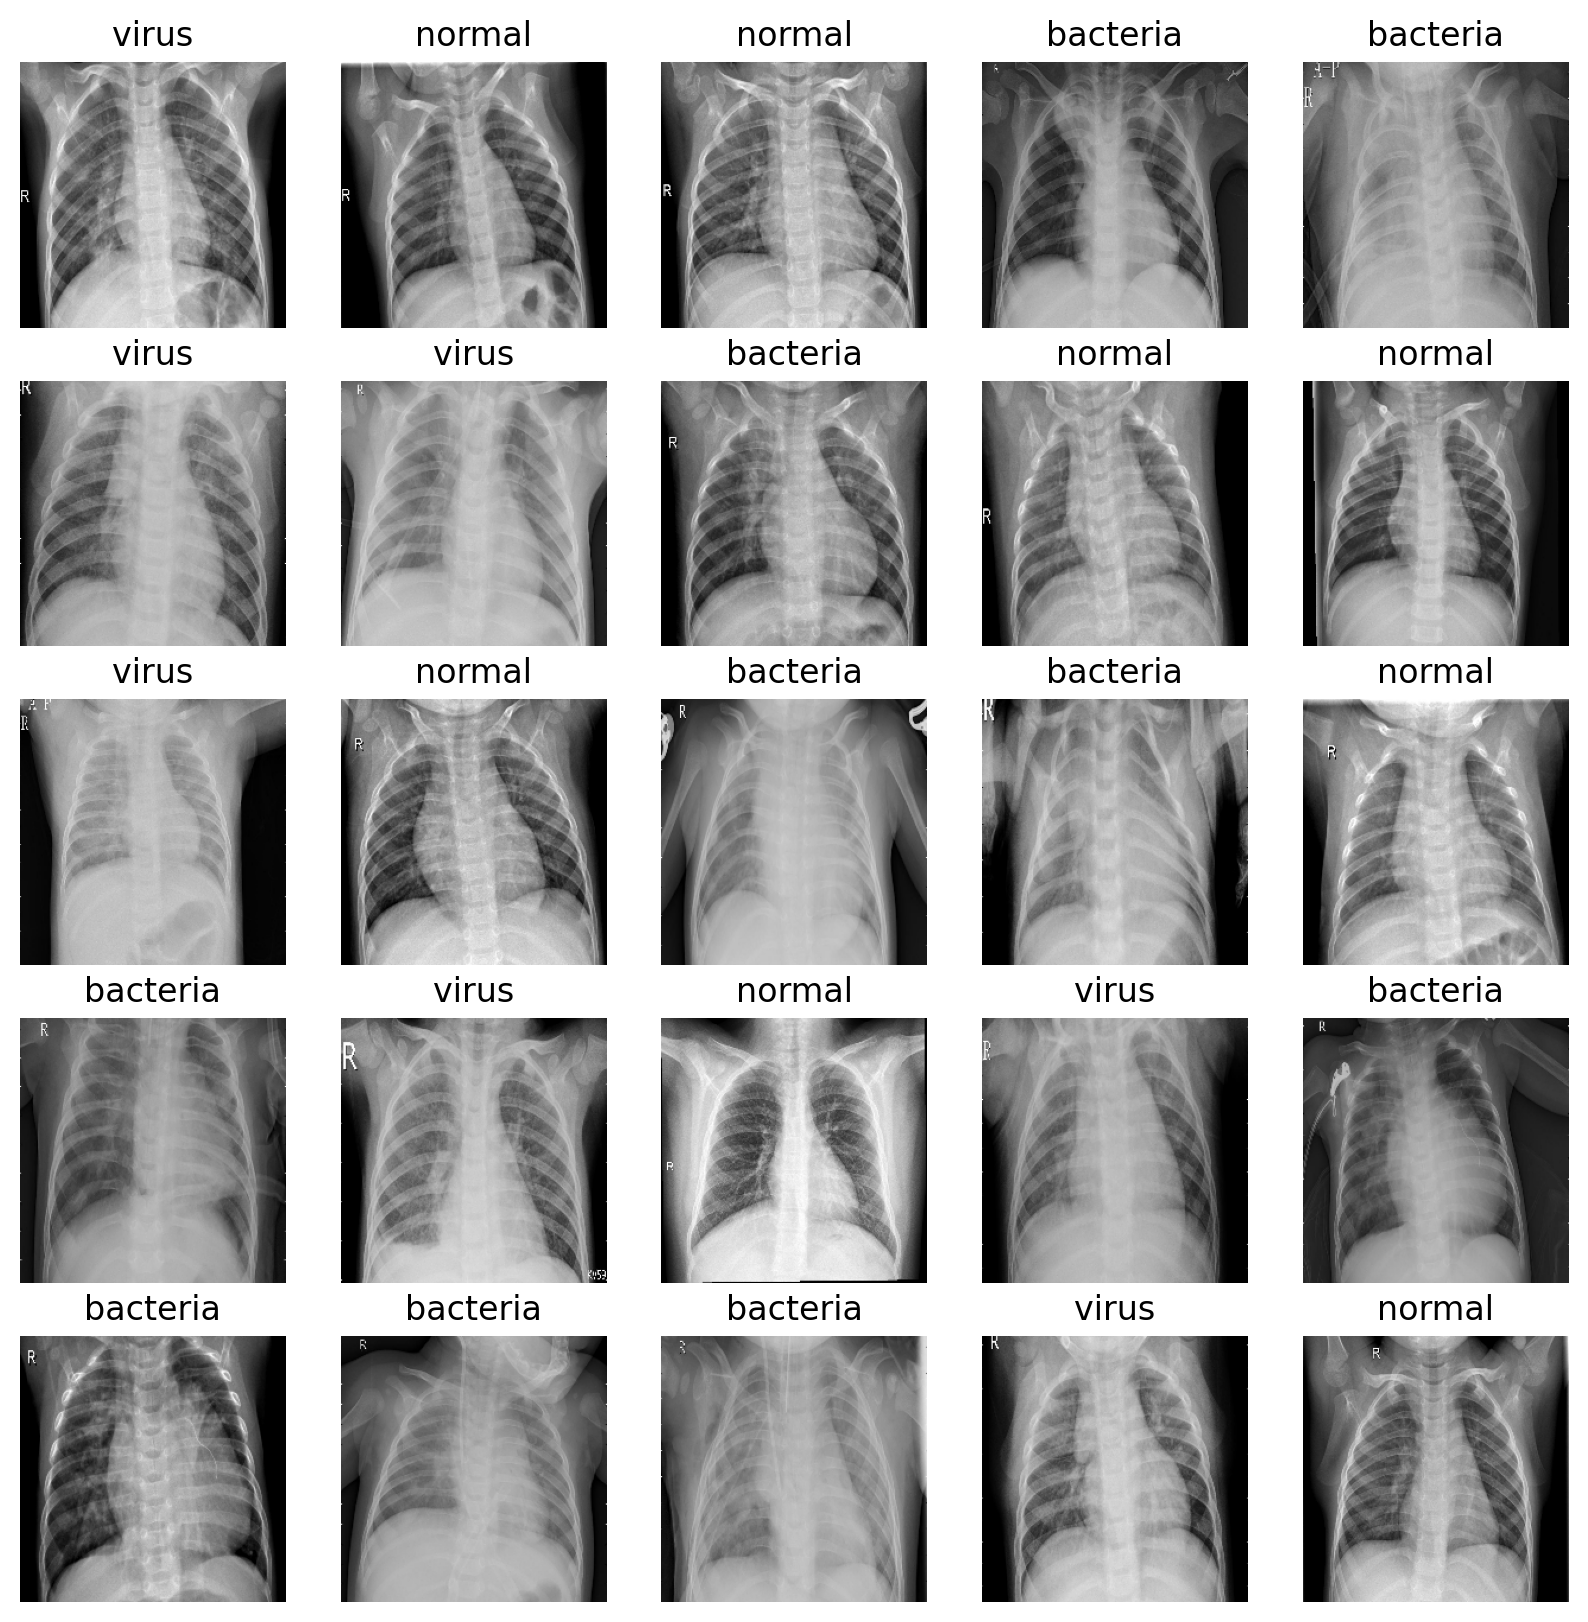

In [ ]:
# Configure retina backend for clearer images
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Plot 25 images and their labels
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for img, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Count number of batches for training and validation sets
train_batches = tf.data.experimental.cardinality(train_ds)
valid_batches = tf.data.experimental.cardinality(valid_ds)

print("Number of training batches: %d" % train_batches)
print("Number of validation batches: %d" % valid_batches)

Number of training batches: 118
Number of validation batches: 30


## **Dataset Configuration for Performance with Prefetching**

Here, prefetching is configured for both training and validation sets. This overlaps the preprocessing and model execution component in the training phase. During training step `T`, the pipeline is already "prefetching" the next round of data for the subsequent step `T + 1`. This reduces the duration to extract the data during the entire training phase.

The internal buffer, which determines the number of elements to prefetch ahead of when they are requested, is configured to `tf.data.AUTOTUNE`, which prompts the `tf.data` runtime to dynamically tune the value.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

## **Create DenseNet-169 base model**

In [ ]:
# Configure image shape for model input shape
IMG_SHAPE = IMG_SIZE + (3,)

# Instantiate base model
base_model = tf.keras.applications.densenet.DenseNet169(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet")

# Freeze convolutional base
base_model.trainable = False

In [ ]:
# Instantiate DenseNet preprocessing method
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [ ]:
# Check output shape of model
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(image_batch.shape, "-->", feature_batch.shape)

# this converts each (160, 160, 3) image to a (7, 7, 1664) block of features

(32, 224, 224, 3) --> (32, 7, 7, 1664)


In [ ]:
# Add global averaging layer
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()

# Check output shape of global averaging layer
feature_batch_avg = global_avg_layer(feature_batch)
print("Feature batch (not averaged) shape:", feature_batch.shape)
print("Feature batch (averaged) shape:", feature_batch_avg.shape)

# this averages over the (7 x 7) spatial locations...
# converting the features to a single 1664-element vector per image

# Add final classification layer
NUM_CLASSES = 3
clf_layer = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")

# Check output shape of classification layer
pred_batch = clf_layer(feature_batch_avg)
print("Prediction batch shape:", pred_batch.shape)

# the dense layer converts the features into a (,3) output...
# representing the probabilities of each predicted class

Feature batch (not averaged) shape: (32, 7, 7, 1664)
Feature batch (averaged) shape: (32, 1664)
Prediction batch shape: (32, 3)


## **Data Augmentation Phase**

In [ ]:
# Add an augmentation layer for additional training data
augment_layer = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(factor=0.2, seed=42),
  tf.keras.layers.RandomBrightness(factor=0.2, seed=42),
  tf.keras.layers.RandomRotation(factor=0.01, seed=42)
])

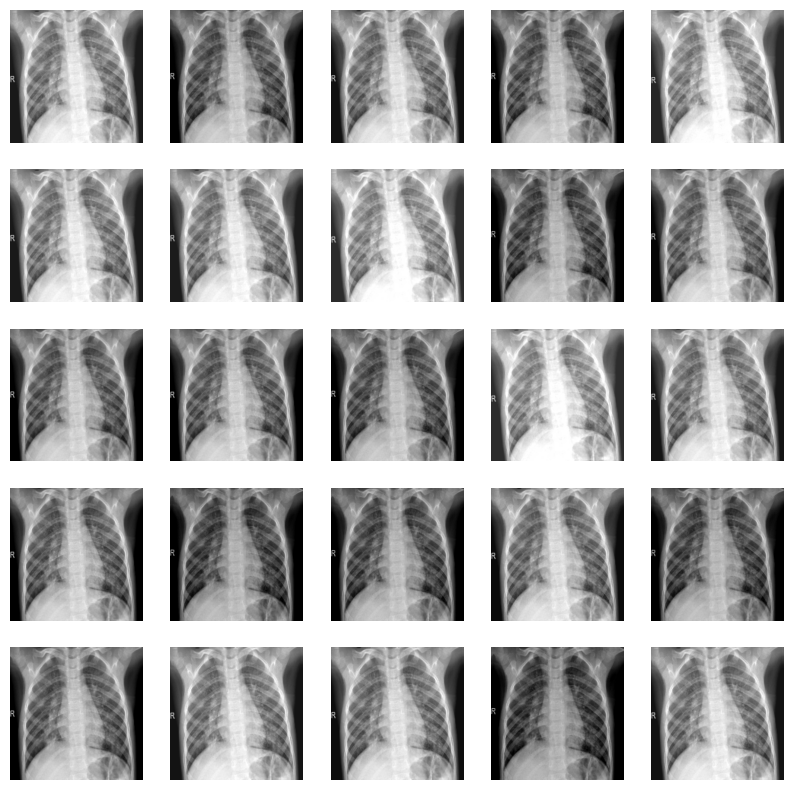

In [ ]:
# Check augmented results
for img, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_img = img[0]

  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    aug_img = augment_layer(tf.expand_dims(first_img, 0))
    plt.imshow(aug_img[0] / 255)
    plt.axis('off')

## **Model Building with Functional API** (change in main code)

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)

# With augmentation:
x = augment_layer(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)    # Prevent training of BN layers
x = global_avg_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Prevent overfitting

outputs = clf_layer(x)
model = tf.keras.Model(inputs, outputs)

# Without augmentation:
# x = preprocess_input(inputs)
# x = base_model(x, training=False)
# x = global_avg_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)

# outputs = clf_layer(x)
# model_unaugmented = tf.keras.Model(inputs, outputs)

## **Metrics Configuration for Multiclass Classification** (check workability)

In [ ]:
# Separate validation data to data and labels for custom metric computation
x_val = np.concatenate([x for x, y in valid_ds], axis=0)
y_val = np.concatenate([y for x, y in valid_ds], axis=0)

In [ ]:
# Create callback to log the following metric scores and write them to TensorBoard
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import matthews_corrcoef

# Create path for saving model weights
checkpoint_path = "../notebooks/tmp/densenet-169-weights"
os.makedirs(checkpoint_path, exist_ok=True)


class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, x_val, y_val, log_dir):
        super().__init__()
        self.model = model
        self.x_val = x_val
        self.y_val = y_val

        # Instantiate macro-averaged metrics
        self._mcc = tf.keras.metrics.Metric("mcc")
        self._aucroc = tf.keras.metrics.Mean("macro_aucroc")
        self._recall = tf.keras.metrics.Mean("macro_recall")
        self._fmeasure = tf.keras.metrics.Mean("macro_fmeasure")
        self._precision = tf.keras.metrics.Mean("macro_precision")

        self.epoch = 0
        self.summary_writer = tf.summary.create_file_writer(
            os.path.join(log_dir, model.name))

    def on_epoch_end(self, batch, logs=None):
        self.epoch += 1
        predictions = self.model.predict(self.y_val)

        self._mcc.reset_state()
        self._aucroc.reset_state()
        self._recall.reset_state()
        self._fmeasure.reset_state()
        self._precision.reset_state()

        mcc = matthews_corrcoef(
            self.y_val, np.argmax(predictions, axis=-1))
        fmeasure = f1_score(
            self.y_val, np.argmax(predictions, axis=-1), average=None)
        recall = recall_score(
            self.y_val, np.argmax(predictions, axis=-1), average=None)
        precision = precision_score(
            self.y_val, np.argmax(predictions, axis=-1), average=None)
        aucroc = roc_auc_score(
            self.y_val, np.argmax(predictions, axis=-1), average=None)

        self._mcc.update_state(mcc)
        self._aucroc.update_state(aucroc)
        self._recall.update_state(recall)
        self._fmeasure.update_state(fmeasure)
        self._precision.update_state(precision)

        self._write_metric(
            self._mcc.name,
            self._mcc.result().numpy().astype(float))
        self._write_metric(
            self._aucroc.name,
            self._aucroc.result().numpy().astype(float))
        self._write_metric(
            self._recall.name,
            self._recall.result().numpy().astype(float))
        self._write_metric(
            self._fmeasure.name,
            self._fmeasure.result().numpy().astype(float))
        self._write_metric(
            self._precision.name,
            self._precision.result().numpy().astype(float))

    def _write_metric(self, name, value):
        with self.summary_writer.as_default():
            tf.summary.scalar(name, value, step=self.epoch)
            self.summary_writer.flush()

metric_callback = [CustomCallback(model, x_val, np.argmax(y_val, axis=-1), "logs")]

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor="val_loss",
                                                         verbose=1,
                                                         mode="min",
                                                         save_weights_only=True)

callbacks = metric_callback + [checkpoint_callback]

## **Model Compilation Phase**

Since the data is not strongly imbalanced, the accuracy score can be used as an evaluation metric.

In [ ]:
# Compile the augmented model

base_lr = 0.0001  # Configure base learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

# Check model architecture
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 5, 5, 1664)        12642880  
                                                           

## **Model Training Phase**

The model is evaluated initially against the validation dataset to test its effectiveness without training. Unsurprisingly, the model performs poorly. Therefore, the model was trained for ten epochs and evaluated based on the validation accuracy score, which increases gradually through each epoch, indicating that the model is effectively learning from the training images. For better visualisation, learning curves are plotted.

In [ ]:
# Evaluate model on validation set without training
eval_loss, eval_accuracy = model.evaluate(valid_ds)

print("initial loss: {:.2f}".format(eval_loss))
print("initial accuracy: {:.2f}".format(eval_accuracy))

30/30 [==============================] - 18s 388ms/step - loss: 2.5418 - accuracy: 0.2821
initial loss: 2.54
initial accuracy: 0.28


In [ ]:
# Train model for ten epochs
epochs = 10

history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=valid_ds,
                    callbacks=callbacks,
                    verbose=1)

# ~80.02% was achieved on the validation set

Epoch 1/10
118/118 [==============================] - 43s 362ms/step - loss: 0.6648 - accuracy: 0.7292 - val_loss: 0.5854 - val_accuracy: 0.7596
Epoch 2/10
118/118 [==============================] - 63s 531ms/step - loss: 0.6271 - accuracy: 0.7351 - val_loss: 0.5681 - val_accuracy: 0.7671
Epoch 3/10
118/118 [==============================] - 69s 579ms/step - loss: 0.6075 - accuracy: 0.7473 - val_loss: 0.5565 - val_accuracy: 0.7692
Epoch 4/10
118/118 [==============================] - 62s 516ms/step - loss: 0.5893 - accuracy: 0.7583 - val_loss: 0.5412 - val_accuracy: 0.7810
Epoch 5/10
118/118 [==============================] - 62s 516ms/step - loss: 0.5731 - accuracy: 0.7601 - val_loss: 0.5256 - val_accuracy: 0.7821
Epoch 6/10
118/118 [==============================] - 60s 499ms/step - loss: 0.5544 - accuracy: 0.7692 - val_loss: 0.5222 - val_accuracy: 0.7959
Epoch 7/10
118/118 [==============================] - 58s 488ms/step - loss: 0.5509 - accuracy: 0.7748 - val_loss: 0.5178 - val_ac

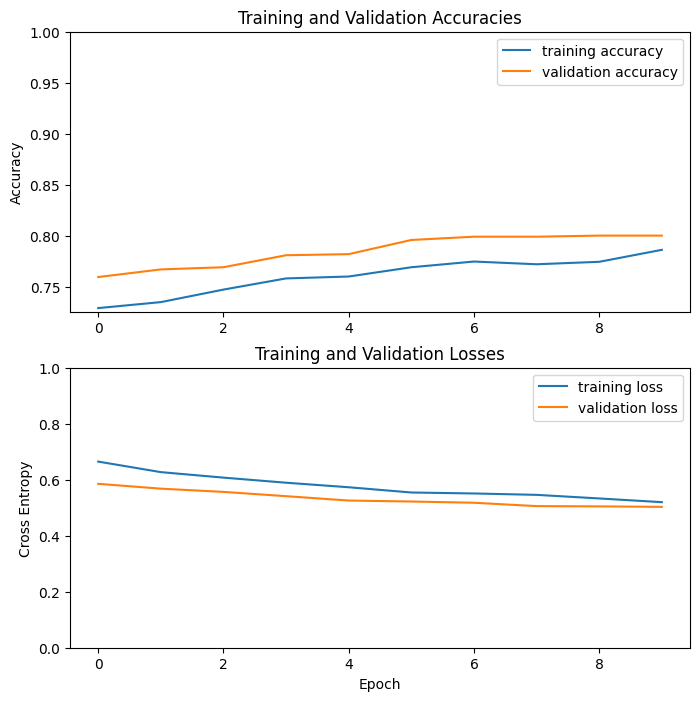

In [ ]:
# Plot the learning curves for training and validation results
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

def plot_learning_curve():

    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(acc, label="training accuracy")
    plt.plot(val_acc, label="validation accuracy")
    plt.legend()
    plt.ylabel("Accuracy")
    plt.ylim([min(plt.ylim()), 1])
    plt.title("Training and Validation Accuracies")

    plt.subplot(2, 1, 2)
    plt.plot(loss, label="training loss")
    plt.plot(val_loss, label="validation loss")
    plt.legend()
    plt.ylabel("Cross Entropy")
    plt.ylim(0, 1.0)
    plt.title("Training and Validation Losses")
    plt.xlabel("Epoch")

    plt.show()

plot_learning_curve()

## **Fine-tuning Phase**

Here, the layers are unfrozen. Only a portion of the model will be configured to trainable. Since the training set is not a large dataset, a smaller number of parameters (only layers after the 500th layer) were unfrozen, to prevent overfitting. Then, the model was compiled with the RMSprop optimiser, which is implemented for its quick convergence times.

In [ ]:
# Unfreeze top layers of model
base_model.trainable = True

# Check base model layers
print("Number of layers in base model:", len(base_model.layers))

In [ ]:
# Freeze all layers before 500 layers
fine_tune_at = 500

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_lr/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

model.summary()

Number of layers in base model: 595


In [ ]:
fine_tune_epochs = 30
total_epochs = epochs + fine_tune_epochs

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=5,
                                               verbose=1,
                                               restore_best_weights=False)

history_tuned = model.fit(train_ds,
                          epochs=total_epochs,
                          initial_epoch=history.epoch[-1],
                          validation_data=valid_ds,
                          callbacks=callbacks+[es_callback],
                          verbose=1)

In [ ]:
# Update metrics
acc += history_tuned.history["accuracy"]
val_acc += history_tuned.history["val_accuracy"]

loss += history_tuned.history["loss"]
val_loss += history_tuned.history["val_loss"]

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label="training accuracy")
plt.plot(val_acc, label="validation accuracy")
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label="start fine tuning")
plt.ylabel("Accuracy")
plt.legend()
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracies")

plt.subplot(2, 1, 2)
plt.plot(loss, label="training loss")
plt.plot(val_loss, label="validation loss")
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label="start fine tuning")
plt.ylabel("Cross Entropy")
plt.ylim(0, 1.0)
plt.legend()
plt.title("Training and Validation Losses")
plt.xlabel("Epoch")

plt.show()